# Transfer Learning for Saliency Prediction

We use transfer learning to predict where people will look in images. We will work with the MIT 1003 dataset which consists of 1003 images together with fixation data from human subjects. Transfer learning allows us to reuse the features from a model that has been pretrained on a larger dataset. Here we will use VGG19 pretrained on ImageNet.

The goals of this assignment are as follows:

*   Extract features from a model pretrained on ImageNet.
*   Implement a simple readout network and train it on the data.
*   Define a loss function and a seperate evaluation metric.
*   Visualize the best and the worst results.


**Importing required libraries.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage import io, transform
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from google.colab import drive

import time

**Get the data**

The MIT 1003 dataset is publicly available at https://people.csail.mit.edu/tjudd/WherePeopleLook/index.html


In [ ]:
# from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_path = "/content/drive/My Drive/Deep_Learning_Goe"
data_path = os.path.join(main_path, "MIT_1003")


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

**Prepare the data**

In [ ]:
images_files_all = [
    os.path.join(data_path, "ALLSTIMULI", f)
    for f in os.scandir(os.path.join(data_path, "ALLSTIMULI"))
    if f.path.endswith(".jpeg")
]
print("Total Number of Images: {} (should be 1003)".format(len(images_files_all)))


Total Number of Images: 1003 (should be 1003)


In [ ]:
# fix the seed for reproducible splitting
np.random.seed(1234)
train_idx = np.random.choice(len(images_files_all), len(images_files_all) // 2, replace=False)
test_idx = np.setdiff1d(np.arange(len(images_files_all)), train_idx)

images_files = {}
images_files["train"] = [images_files_all[i] for i in train_idx]
images_files["test"] = [images_files_all[i] for i in test_idx]
print("Number of Train Images: {}".format(len(images_files["train"])))
print("Number of Test Images: {}".format(len(images_files["test"])))

fixation_maps_binary_files = {}
fixation_maps_binary_files["train"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixPts.jpg")
    for filename in images_files["train"]
]
fixation_maps_binary_files["test"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixPts.jpg")
    for filename in images_files["test"]
]
fixation_maps_blurred_files = {}
fixation_maps_blurred_files["train"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixMap.jpg")
    for filename in images_files["train"]
]
fixation_maps_blurred_files["test"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixMap.jpg")
    for filename in images_files["test"]
]


Number of Train Images: 501
Number of Test Images: 502


**Show an example from the dataset**

In [ ]:
image = io.imread(images_files["train"][0])
binary_map = io.imread(fixation_maps_binary_files["train"][0])
blurred_map = io.imread(fixation_maps_blurred_files["train"][0])
fixations = np.where(binary_map)


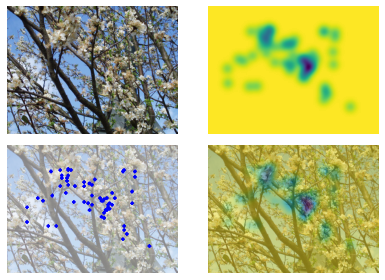

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.axis("off")
ax1.imshow(image)
ax2.axis("off")
ax2.imshow(blurred_map, cmap="viridis_r")
ax3.axis("off")
ax3.imshow(image, alpha=0.5)
ax3.scatter(fixations[1], fixations[0], s=1, marker=".", c="b")
ax4.axis("off")
ax4.imshow(image)
ax4.imshow(blurred_map, alpha=0.5, cmap="viridis_r")
fig.tight_layout()


**Preprocess images and maps**

The images have different sizes and orientations. To simplify our task we downscale the images and crop them to a size of 256x256 pixels. At this size, all of the images should fit into memory at once.

In [ ]:
def preprocess_data(images_paths, fixations_binary_paths, fixations_blurred_paths, shape):
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(shape),
            torchvision.transforms.CenterCrop(shape),
        ]
    )

    n = len(images_paths)
    ims = np.empty((n, shape, shape, 3), dtype=np.int)
    fixs_binary = np.empty((n, shape, shape))
    fixs_blurred = np.empty((n, shape, shape))

    for i, path in enumerate(tqdm(images_paths)):
        image = io.imread(path)
        image = transform(image)
        image = np.array(image, dtype=np.int)
        ims[i] = image

    for i, path in enumerate(tqdm(fixations_binary_paths)):
        fixations_binary = io.imread(path, 0)
        fixations_binary = transform(fixations_binary)
        fixations_binary = np.array(fixations_binary)
        fixs_binary[i] = fixations_binary

    for i, path in enumerate(tqdm(fixations_blurred_paths)):
        fixations_blurred = io.imread(path, 0)
        fixations_blurred = transform(fixations_blurred)
        fixations_blurred = np.array(fixations_blurred)
        fixs_blurred[i] = fixations_blurred

    data = {"images": ims, "fixations_binary": fixs_binary, "fixations_blurred": fixs_blurred}
    return data


In [ ]:
# If data is already preprocessed and saved, load it, otherwise preprocess and save it.
# If you do not whish to save the data comment the according lines.
# If you want to re-run data preprocessing, you may have to delete the saved file.

train_data_file = os.path.join(main_path, "train_data.npy")

if os.path.isfile(train_data_file):
    train_data = np.load(train_data_file, allow_pickle=True)[()]
else:
    train_data = preprocess_data(
        images_files["train"], fixation_maps_binary_files["train"], fixation_maps_blurred_files["train"], 256
    )
    np.save(train_data_file, train_data)


**Implement a PyTorch dataset for our data**

We need the `torch.utils.data.Dataset`  to access the data conveniently. Later, it is required to have access to the data through this class to build a Pytorch dataloader.

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_data, features=None):
        self.features = features
        self.data = preprocessed_data

    def __getitem__(self, key):
        raw_image = self.data["images"][key]

        normalized_image = raw_image.astype(np.float32) / 255.0  # -> [0, 1]
        normalized_image -= np.array([0.485, 0.456, 0.406])  # subtract mean
        normalized_image /= np.array([0.229, 0.224, 0.225])  # divide by SD
        normalized_image = normalized_image.transpose(2, 0, 1)  # HWC -> CHW

        fixations_binary = self.data["fixations_binary"][key]
        fixations_blurred = self.data["fixations_blurred"][key]

        data = {
            "raw_image": raw_image,
            "normalized_image": normalized_image,
            "fixations_binary": fixations_binary,
            "fixations_blurred": fixations_blurred,
        }

        if self.features is not None:
            data["features"] = self.features[key]

        return data

    def __len__(self):
        return len(self.data["images"])


The collate_fn will be used in the dataloader. It converts the batched data into tensors. We use a sparse tensor for the binary fixations because they contain mostly zeros.

In [ ]:
def to_sparse(x):
    """converts dense tensor x to sparse format"""
    x_typename = torch.typename(x).split(".")[-1]
    sparse_tensortype = getattr(torch.sparse, x_typename)

    indices = torch.nonzero(x)
    if len(indices.shape) == 0:  # if all elements are zeros
        return sparse_tensortype(*x.shape)
    indices = indices.t()
    values = x[tuple(indices[i] for i in range(indices.shape[0]))]
    return sparse_tensortype(indices, values, x.size())


def collate_fn(batch):
    batch_data = {
        "image": torch.tensor([item["normalized_image"] for item in batch]),
        "fixations_binary": to_sparse(torch.tensor([item["fixations_binary"] for item in batch])),
        "fixations_blurred": torch.tensor([item["fixations_blurred"] for item in batch]),
    }
    if "features" in batch[0].keys():
        batch_data["features"] = torch.tensor([item["features"] for item in batch], dtype=torch.float)
    return batch_data


**Compute center bias**

People tend to look towards the center of the image. This is both due to a bias in our expectations as well as the tendency of photographers to place the interesting objects in the center of the photo. Thus, in the fixation data there is a bias towards the center of the image. We incorporate this bias into our model explicitly.

**TO DO:** To compute the center bias,
1. sum all the binary fixation maps,
1. normalize by dividing through the maximum value
1. apply a Gaussian filter with standard deviation 10 to smooth the result
1. and compute the natural logarithm


In [ ]:
from scipy.ndimage import gaussian_filter

# Instantiate the pytorch dataset. (Note that although it contains the same data,
# as `train_data` above, the objects are different. Here, we could use `train_data`)
# instead of `dataset_train`, however, to build a pytorch dataloader later, we
# have to use the `dataset_train` object.

dataset_train = ImageDataset(train_data)
fixations_binary = dataset_train.data["fixations_binary"]


In [ ]:
np.shape(fixations_binary)

(501, 256, 256)

In [ ]:
np.shape(fixations_binary[0])

(256, 256)

In [ ]:
dataset_train.data['images'].shape

(501, 256, 256, 3)

In [ ]:
# TODO
fixations_sum = np.sum(fixations_binary, 0, keepdims=True)
fixation_norm = fixations_sum / np.max(fixations_sum)
center_bias = np.log(gaussian_filter(fixation_norm, sigma=10))  # (should be 1 x 256 x 256)
print(np.shape(center_bias))

(1, 256, 256)


Plot the result

Text(0.5, 1.0, 'Center bias')

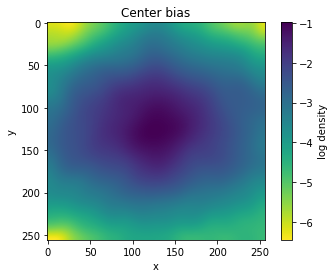

In [ ]:
plt.figure()
plt.imshow(center_bias[0], cmap="viridis_r")
cb = plt.colorbar().set_label("log density")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Center bias")


Your plot should look like this:

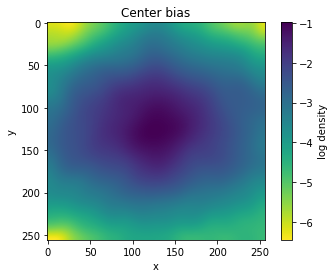

Save/Load center bias

In [ ]:
center_bias_file = os.path.join(main_path, "center_bias.npy")

if os.path.isfile(center_bias_file):
    center_bias = np.load(center_bias_file)
else:
    np.save(center_bias_file, center_bias)


**Extract feature maps**

Load the VGG19 model pretrained on ImageNet. Use it to process the images in the train dataset: For each image, extract its feature map representation from the Conv2d layer `vgg19.features[30]`. For that, you have to constraint the vgg19 model such that all it's layers up to (including) layer 30 process the image. The subsequent layers of the model are not required to extract the feature maps. You should save them in a Numpy array of shape `(num_feature_map_representations, num_channels, x, y)`.

In [ ]:
#TODO
vgg = models.vgg19(pretrained=True) # VGG model: https://arxiv.org/abs/1409.1556
feature_extractor = vgg.features.eval()

In [ ]:
feature_extractor = feature_extractor[0:-6] # all layers until but including vgg19.features[30]
print(feature_extractor)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
dataset_train_tmp = ImageDataset(train_data)

data_loader_train_tmp = torch.utils.data.DataLoader(dataset_train_tmp,
                                                    shuffle=False,
                                                    batch_size=1,
                                                    collate_fn=collate_fn,
                                                    pin_memory=False)

In [ ]:
def compute_train_features(): # TODO
  features = torch.empty(501, 512, 16, 16)
  with torch.no_grad():
    for i, dataloader in enumerate(data_loader_train_tmp):
      foo = dataloader['image']#.to(device)
      features[i] = feature_extractor(foo)

  return features

**Save the features to a file**

Processing the images can take a few minutes. However, you only have to do it once. Thus it is a good idea to save the features to a file that you can load again later.

In [ ]:
features_file = os.path.join(main_path, "features_train.npy")

if os.path.isfile(features_file):
    features = np.load(features_file)

else:
    features = compute_train_features()

    # check if feature maps are computed correctly
    # fmt: off
    expected_values = np.array(
    [[ -7.99193907 ,  -9.97434425 ,  -6.30443621 ,  -5.38638353 ,  -4.27384281,
    -4.0693121  ,  -5.75616169 ,  -6.48476934 ,  -5.98380566 ,  -6.52242613],
    [-12.36434174 , -16.65618324 , -11.27461529 ,  -8.19952297 ,  -3.27289772,
    -1.19771433 ,  -3.19741416 ,  -6.47992802 ,  -6.5870204  ,  -7.18390512],
    [-11.13755226 , -15.65487099 , -12.64397049 ,  -7.71314335 ,  -2.45429325,
        0.83334196 ,  -0.64034951 ,  -5.03683281 ,  -4.65806484 ,  -4.50047112],
    [-10.5068655  , -14.42764664 , -10.61693573 ,  -5.19931602 ,  -1.12161112,
        0.89836073 ,  -0.5252769  ,  -3.71349239 ,  -2.97045493 ,  -2.79023504],
    [ -7.34475327 , -10.47937965 ,  -7.02888393 ,  -3.53863454 ,  -0.80185205,
    -0.74341547 ,  -1.12742841 ,  -2.42642498 ,  -2.1918633  ,  -2.38320088],
    [ -6.56508207 , -10.2462101  ,  -7.95301008 ,  -5.73207569 ,  -2.83811665,
    -3.51840949 ,  -3.68543339 ,  -3.03833508 ,  -3.84370446 ,  -3.34144878],
    [ -7.19058847 , -11.19171238 , -10.3939085  ,  -9.02087402 ,  -7.91058254,
    -8.43811989 ,  -7.81550455 ,  -6.3780117  ,  -7.06438923 ,  -4.87577438],
    [ -6.39207697 ,  -9.84247875 , -10.04116726 ,  -9.37077713 ,  -9.32631779,
    -8.01702595 ,  -8.88777161 ,  -7.13604116 ,  -6.65273285 ,  -4.70653677],
    [ -5.39928961 ,  -8.16330624 ,  -9.64505863 , -10.31910038 , -11.08797836,
    -9.06617165 ,  -8.1905756  ,  -7.1117115  ,  -5.28658915 ,  -3.31289601],
    [ -6.93690252 ,  -8.61090851 ,  -8.46377468 ,  -8.70087719 , -10.07951546,
    -9.06166553 ,  -7.16104031 ,  -6.44536161 ,  -4.36636829 ,  -1.53092551]]
    )
    # fmt: on
    assert np.allclose(features[0, 0, :10, :10], expected_values), "Feature maps look different than expected"

    np.save(features_file, features)


In [ ]:
features = np.array(features)
print(features.shape)

(501, 512, 16, 16)


In [ ]:
features[0,0,:10,:10] # works correctly

array([[ -7.991939  ,  -9.974344  ,  -6.304436  ,  -5.3863835 ,
         -4.273843  ,  -4.069312  ,  -5.7561617 ,  -6.4847693 ,
         -5.9838057 ,  -6.522426  ],
       [-12.364342  , -16.656183  , -11.274615  ,  -8.199523  ,
         -3.2728977 ,  -1.1977143 ,  -3.1974142 ,  -6.479928  ,
         -6.5870204 ,  -7.183905  ],
       [-11.137552  , -15.654871  , -12.6439705 ,  -7.7131433 ,
         -2.4542933 ,   0.83334196,  -0.6403495 ,  -5.036833  ,
         -4.658065  ,  -4.500471  ],
       [-10.5068655 , -14.427647  , -10.616936  ,  -5.199316  ,
         -1.1216111 ,   0.8983607 ,  -0.5252769 ,  -3.7134924 ,
         -2.970455  ,  -2.790235  ],
       [ -7.3447533 , -10.47938   ,  -7.028884  ,  -3.5386345 ,
         -0.80185205,  -0.7434155 ,  -1.1274284 ,  -2.426425  ,
         -2.1918633 ,  -2.383201  ],
       [ -6.565082  , -10.24621   ,  -7.95301   ,  -5.7320757 ,
         -2.8381166 ,  -3.5184095 ,  -3.6854334 ,  -3.038335  ,
         -3.8437045 ,  -3.3414488 ],
       [ -

Add the features to the dataset and define a data loader for training our model. Feel free to change the batch size.

In [ ]:
dataset_train = ImageDataset(train_data, features=features)

data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=64,
    collate_fn=collate_fn,
    pin_memory=False)


**Define the model**

Now we need to define the model we want to train. Two parts are necessary:

1. Readout Network

The readout network gets the feature maps we extracted from VGG19 as input. The network could be of arbitrary complexity but in our case we want to keep it simple: it contains only one layer that takes a linear combination of the features at each location (using 1x1 convolution).

2. Finalizer

The finalizer takes the output of the readout network and scales it up to the size of our images (256x256). It then applies a Gaussian filter to blur the result of the upscaling and adds the center bias. Finally, it performs normalization using a (log) softmax to return the logarithm of the fixation probability densities, later refered to as `log_density`.

*Hints:*
- What are in- and out-shapes of the readout network? What are the parameters you have to pass to the constructor of the 1x1 convolution, then?
- Don't forget to give a learnable weight to the center bias, $\alpha$ in [Kümmerer, Theis, and Bethge (2015)](https://arxiv.org/abs/1411.1045).
- In `Finalizer` below, initialize `self.gaussian_blur = GaussianBlur2d()` and use `self.gaussian_blur` in `forward(...)`.
- You might want to use `F.interpolate`
- The finalizer output is of shape `(batch, x_pixels, y_pixels)`
- Log softmax: As the finalizer should return the logarithm of the fixation probabilities, here is a hint rewriting the math of the paper cited above accordingly:
$$\ln p(x, y) =\ln \frac{\exp (o(x, y))}{\sum_{x, y} \exp (o(x, y))} = \ ?$$
$$ =\ln (\exp (o(x, y))) - log(\sum_{x, y} \exp (o(x, y))$$
$$ =o(x, y) - log(\sum_{x, y} \exp (o(x, y))$$
(Note that in the paper $\log$ refers to the natural logarithm $\ln$. Ignore the regularization term in this step). Hence, we recommend you to use `logsumexp` to compute the softmax in log-space.

In [ ]:
class GaussianBlur2d(nn.Module):
    """
    This class applies a Gaussian filter to a tensor. You should
    use it *after* upscaling to image size (256x256). The kernel
    size and the standard deviation are fixed and you don't need
    to change them.
    """

    def __init__(self):
        super().__init__()

        self.kernel_size = 121
        self.sigma = 20
        self.pad = 60

        grid = torch.arange(float(self.kernel_size)) - self.pad

        kernel_shape_x = [1] * 4
        kernel_shape_x[3] = self.kernel_size
        grid_x = nn.Parameter(grid.view(kernel_shape_x), requires_grad=False)
        self.kernel_x = torch.exp(-0.5 * (grid_x / self.sigma) ** 2)
        self.kernel_x = self.kernel_x / self.kernel_x.sum()

        kernel_shape_y = [1] * 4
        kernel_shape_y[2] = self.kernel_size
        grid_y = grid.view(kernel_shape_y)
        self.kernel_y = torch.exp(-0.5 * (grid_y / self.sigma) ** 2)
        self.kernel_y = self.kernel_y / self.kernel_y.sum()

    def forward(self, tensor):
        """Applies the gaussian filter to the given tensor"""
        out = F.conv1d(tensor, self.kernel_x, padding=self.pad)
        out = F.conv1d(out, self.kernel_y)

        return out


In [ ]:
#TODO
# contains only one layer that takes a linear combination of the features at each location (using 1x1 convolution)
readout_network = nn.Conv2d(512, 1, kernel_size=(1, 1))

In [ ]:
class Finalizer(nn.Module):
    """Returns logarithm of the fixation probability densities, shape: (batch, x_size, y_size)"""
    '''
    1. takes output of the readout network and scales it up to the size of our images (256x256).
    2. applies a Gaussian filter to blur the result of the upscaling and adds the center bias.
    3. performs normalization using a (log) softmax to return the logarithm of the fixation probability densities, later refered to as log_density.
    '''

  # TODO
    def __init__(self):
      super().__init__()
      self.alpha   = torch.nn.Parameter(torch.rand(1) )
      self.alpha.requires_grad = True
      self.gaussian_blur = GaussianBlur2d()

    def forward(self, x, centerbias):

      out = F.interpolate(input=x, size=(256, 256))             # 1.
      out = self.gaussian_blur(out)       #shape: -1, 256, 256  # 2.

      out = out + self.alpha * centerbias                       # 2.
      out = out.view(-1, 256, 256)
      out = out - torch.logsumexp(out, (1,2))[:, None, None]    # 3.
      return out


In [ ]:
class Model(nn.Module):
    def __init__(self, readout_network, finalizer):
        super().__init__()
        self.readout_network = readout_network
        self.finalizer = finalizer

    def forward(self, x, centerbias):
        x = self.readout_network(x)
        x = self.finalizer(x, centerbias)
        return x

    def train(self, mode=True):
        self.readout_network.train(mode=mode)
        self.finalizer.train(mode=mode)


In [ ]:
finalizer = Finalizer()
model = Model(readout_network, finalizer)

**Define the metrics**

We use two different metrics, one for training and one for evaluating the performance of our model. Remember that we did this for the past exercises, too: back then, we used the cross-entropy loss for training and accuracy for validation.

Here, for the training, we use the negative log-likelihood (NLL). Implement a function that calculates the negative log-likelihood of a fixation mask (which are the labels in our data) under the model prediction `log_density` (i.e. the logarithm of the fixation probability density maps).

*Hints:*
The negative log-likelihood we want to use is a slight modification of the equation (last one on page 3) given in Kümmerer, Theis, and Bethge (2015): we ignore the regularization term. Hence, we obtain

$$c(\alpha, w)=-\frac{1}{N} \sum_{i=1}^{N} \ln \hat{p}\left(x_{i}, y_{i}\right) \ .$$

In this NLL we evaluate the model's predicted fixation probability $\hat{p}$ at the positions $(x_i,y_i)$ of each fixation $i \in \{1, ..., N\}$ measured in the experiments. Note that the elements in the binary fixation masks $f(x_j, y_k)$ (our labels) count how many fixations ocurred at position $(x_j, y_k)$.

Let's rewrite the NLL in a way you can directly implement into code: We compute the inner product of the model predictions at all spatial coordinates $\hat{p}(x_j, y_k)$ and ground truth binary fixation masks $f(x_j, y_k)$ and divide by the fixation count $N$. Additionally, we compute the mean over images $b$ in our batch. This way, we obtain

$$\tilde{c}(\alpha, w) = \frac{1}{b} \sum_b^B \underbrace{ (-1) \frac{1}{N} \sum_{j,k} \ln (\hat{p}(x_{j}, y_{k} |\, \mathrm{image} \ b)) \cdot f(x_{j},y_{k} |\, \mathrm{image} \ b) }_{c(\alpha, w)} \ .$$


In [ ]:
def neg_log_likelihood(log_density, fixation_mask):
    #TODO
    fixation_mask = fixation_mask.to_dense()

  # fixation_count = fixation_mask.sum(dim = (1,2), keepdim = True) # B,1,1

  # output = torch.mean(torch.sum(log_density*fixation_mask, dim = (1,2), keepdim = True) / fixation_count)

    out = 0
    batch_size = fixation_mask.shape[0]
    for b in range(batch_size):
      foo = torch.zeros(256, 256)
      foo[torch.where(fixation_mask[b])[0], torch.where(fixation_mask[b])[1]] = 1
      N = foo.sum()
      foo = foo.view(1, -1)
      out -= torch.matmul(log_density[b].view(1, -1), foo.t())/ N
    return out/batch_size

For evaluation, we want to use the *normalized scanpath saliency* (NSS; [Peters, Iyer, Itti, and Koch (2005), Section 2.10](https://doi.org/10.1016/j.visres.2005.03.019)). To compute NSS, normalize the model's saliency map (prediction) $\mathrm{SM}(x,y)$ to have zero mean and unit standard deviation,

$$Z_{\mathrm{SM}}(x,y) = \frac{\mathrm{SM}(x,y) - \mu}{\sigma}\ ,$$

where $\mu$ and $\sigma$ are the mean and the standard deviation of the saliency map, respectively. Then, average the according responses at all fixations $(x_i,y_i)$,

$$\mathrm{NSS} = \frac{1}{N} \sum_{i=1}^N Z_{\mathrm{SM}}(x_i,y_i)\ .$$

Implement this as a function.

*Hints:*
- Here, the saliency map $\mathrm{SM}(x,y)$ is *not* in log-space, i.e. the saliency map is given as exponential of the `log_density` that the model would predict, $\mathrm{e}^{\hat{p}(x, y)}$.
- Remember the hints from above:
    - How can you rewrite/implement the sum over fixation points in terms of a inner product of the normlized saliency map and the binary fixation mask?
    - Compute the mean across batches

In [ ]:
def nss(log_density, fixation_mask):
    #TODO
    density = torch.exp(log_density)
    stand_density = density - torch.mean(density, (1,2))[:, None, None]
    stand_density = stand_density/torch.std(density, (1,2))[:, None, None]

    fixation_mask = fixation_mask.to_dense()
    out = 0
    batch_size = fixation_mask.shape[0]
    for b in range(batch_size):
      foo = torch.zeros(256, 256)
      foo[torch.where(fixation_mask[b])[0], torch.where(fixation_mask[b])[1]] = 1
      N = foo.sum()
      foo = foo.view(1, -1)
      out += torch.matmul(stand_density[b].view(1, -1), foo.t())/ N
    return out/batch_size

**Train the model**

Now iterate through the dataloader to train the model on the train dataset. You can use the Adam optimizer with default parameters. You should print the NLL and the NSS of the train dataset after each training epoch to monitor the progress. Train for at least 5 epochs. You are welcome to reuse and adapt the code you used on the previous exercise sheets for model training, but you don't have to.


In [ ]:
def run_training(model, train_dataset, num_epoch, centerbias, optimizer, scheduler=None):
    #TODO
    start_time = time.time()
    num_iter = np.ceil(501/64).astype(int)

    for epoch in range(num_epoch):
      for i, dataloader in enumerate(train_dataset):
        optimizer.zero_grad()
        model.train()

        features = dataloader['features']
        fixations = dataloader['fixations_binary']

        pred = model(features, centerbias)
        NLL  = neg_log_likelihood(pred, fixations)
        NSS  = nss(pred, fixations)

        NLL.backward()
        optimizer.step()

        if scheduler:
          scheduler.step()


        print(f'Epoch [{epoch+1}/{num_epoch}], Step [{i+1}/{num_iter}], NLL: {NLL.item():.2f}, NSS: {NSS.item():.2f}' )

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')

    return print('Done!')

In [ ]:
num_epoch = 5
lr_initial = 1e-2
finalizer = Finalizer()
model = Model(readout_network, finalizer)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_initial)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

run_training(model, data_loader_train, num_epoch=num_epoch, centerbias=torch.tensor(center_bias, dtype=torch.float), optimizer=optimizer, scheduler=scheduler)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  app.launch_new_instance()


Epoch [1/5], Step [1/8], NLL: 11.94, NSS: 0.31
Epoch [1/5], Step [2/8], NLL: 14.15, NSS: 1.03
Epoch [1/5], Step [3/8], NLL: 13.91, NSS: 1.07
Epoch [1/5], Step [4/8], NLL: 11.49, NSS: 1.16
Epoch [1/5], Step [5/8], NLL: 10.89, NSS: 1.04
Epoch [1/5], Step [6/8], NLL: 12.44, NSS: 0.09
Epoch [1/5], Step [7/8], NLL: 11.81, NSS: 0.49
Epoch [1/5], Step [8/8], NLL: 10.91, NSS: 1.03
Epoch [2/5], Step [1/8], NLL: 10.80, NSS: 1.38
Epoch [2/5], Step [2/8], NLL: 10.98, NSS: 1.40
Epoch [2/5], Step [3/8], NLL: 11.07, NSS: 1.41
Epoch [2/5], Step [4/8], NLL: 11.08, NSS: 1.31
Epoch [2/5], Step [5/8], NLL: 10.85, NSS: 1.59
Epoch [2/5], Step [6/8], NLL: 10.82, NSS: 1.62
Epoch [2/5], Step [7/8], NLL: 10.68, NSS: 1.66
Epoch [2/5], Step [8/8], NLL: 10.59, NSS: 1.58
Epoch [3/5], Step [1/8], NLL: 10.34, NSS: 1.68
Epoch [3/5], Step [2/8], NLL: 10.35, NSS: 1.66
Epoch [3/5], Step [3/8], NLL: 10.46, NSS: 1.42
Epoch [3/5], Step [4/8], NLL: 10.43, NSS: 1.45
Epoch [3/5], Step [5/8], NLL: 10.39, NSS: 1.55
Epoch [3/5], 

You can save the model to disk if you want to.

In [ ]:
model_file = os.path.join(main_path, 'model_name.torch')

if os.path.isfile(model_file):
    model.load_state_dict(torch.load(model_file))
    model.eval()
else:
    #%time run_training(model, data_loader_train, torch.tensor(center_bias, dtype=torch.float))
    torch.save(model.state_dict(), model_file)

# get the scores for the test data

In [ ]:
test_data = preprocess_data(
    images_files["test"], fixation_maps_binary_files["test"], fixation_maps_blurred_files["test"], 256)

100%|██████████| 502/502 [01:17<00:00,  6.45it/s]


Here you need to extract the same feature maps as you extracted before, but now for the test images instead of the trining images. It works the same way as before for the train dataset.

In [ ]:
dataset_test_tmp = ImageDataset(test_data)

data_loader_test_tmp = torch.utils.data.DataLoader(dataset_test_tmp,
                                                   shuffle=False,
                                                   batch_size=1,
                                                   collate_fn=collate_fn,
                                                   pin_memory=False)

In [ ]:
def compute_test_features():  # TODO
  features_test = torch.empty(502, 512, 16, 16)
  with torch.no_grad():
    for i, dataloader in enumerate(data_loader_test_tmp):
      foo = dataloader['image']#.to(device)
      features_test[i] = feature_extractor(foo)

  return features_test

save / load

In [ ]:
features_test_file = os.path.join(main_path, "features_test.npy")

if os.path.isfile(features_test_file):
  features_test = np.load(features_test_file)
else:
  features_test = compute_test_features()
  np.save(features_test_file, features_test)


Get the NSS scores for each test image. Print the three highest NSS scores. In our reference implementation, we got `[6.0, 7.1, 7.3]`.

In [ ]:
dataset_test = ImageDataset(test_data, features=features_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    shuffle=False,
    batch_size=1,
    collate_fn=collate_fn,
    pin_memory=False,
)


In [ ]:
#TODO
scores_nss = []
centerbias = torch.tensor(center_bias, dtype=torch.float)
with torch.no_grad():
  for i, dataloader in enumerate(data_loader_test):
    features = dataloader['features']
    fixations = dataloader['fixations_binary']

    pred = model(features, centerbias)
    NSS  = nss(pred, fixations)
    scores_nss.append(NSS)
    if i % 100 == 0:
      print(f'Test Image [{i+1}/{len(data_loader_test)}], NSS: {NSS.item():.2f}' )


Test Image [1/502], NSS: 1.04
Test Image [101/502], NSS: 1.79
Test Image [201/502], NSS: 0.53
Test Image [301/502], NSS: 1.24
Test Image [401/502], NSS: 0.75
Test Image [501/502], NSS: 0.63


In [ ]:
scores_nss = torch.tensor(scores_nss)

best_val, best_idx = torch.topk(scores_nss, k=3)                  # largest k scores
worst_val, worst_idx = torch.topk(scores_nss, k=3, largest=False) # smallest k scores
print(best_val)
print(worst_val)

tensor([5.0587, 4.8518, 4.7815])
tensor([-0.0842,  0.1103,  0.1534])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


**Inspect the results**

Let's find out how well your model performs. Use the given plot function to visualize the saliency maps for
1. the three elements of the test dataset with the *highest NSS* and
2. the three elements of the test dataset with the *lowest NSS*.

Print the respective NSS values.

**Display test images with highest scores**

For the images with the highest scores the predicted saliency map should look very similar to the observed fixation map.

Here is an example:

![alt text](https://i.imgur.com/qgUQG2W.png)

In [ ]:
def plot(image, fixations, blurred_map, prediction):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

    ax1.axis("off")
    ax1.imshow(image)
    ax1.set_title("original image")

    ax2.axis("off")
    ax2.imshow(blurred_map, cmap="viridis_r")
    ax2.set_title("blurred fixation map")

    ax3.axis("off")
    ax3.imshow(prediction, cmap="viridis_r")
    ax3.set_title("model prediction")

    ax4.axis("off")
    ax4.imshow(image, alpha=0.5)
    ax4.scatter(fixations[1], fixations[0], s=10, marker=".", c="b")
    ax4.set_title("overlayed with discrete fixations")

    ax5.axis("off")
    ax5.imshow(image)
    ax5.imshow(blurred_map, alpha=0.5, cmap="viridis_r")
    ax5.set_title("overlayed with original image")

    ax6.axis("off")
    ax6.imshow(image)
    ax6.imshow(prediction, alpha=0.5, cmap="viridis_r")
    ax6.set_title("overlayed with original image")


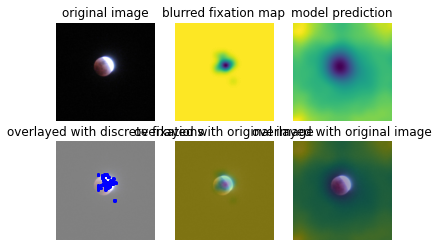

In [ ]:
# TODO
# First best
idx = best_idx[0]
with torch.no_grad():
  best_img = dataset_test[idx]['raw_image']
  best_fix = np.where(dataset_test[idx]['fixations_binary'])
  best_blurr = dataset_test[idx]['fixations_blurred']
  best_pred = model(torch.tensor(dataset_test[idx]['features'], dtype=torch.float).view(1, 512, 16, 16), centerbias).view(256,256)

plot(best_img, best_fix, best_blurr, best_pred)

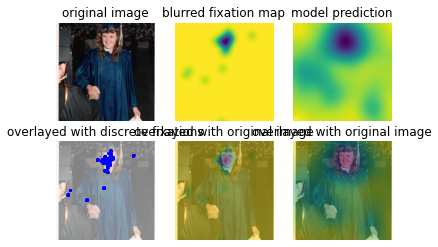

In [ ]:
# Second best
idx = best_idx[1]
with torch.no_grad():
  best_img = dataset_test[idx]['raw_image']
  best_fix = np.where(dataset_test[idx]['fixations_binary'])
  best_blurr = dataset_test[idx]['fixations_blurred']
  best_pred = model(torch.tensor(dataset_test[idx]['features'], dtype=torch.float).view(1, 512, 16, 16), centerbias).view(256,256)

plot(best_img, best_fix, best_blurr, best_pred)

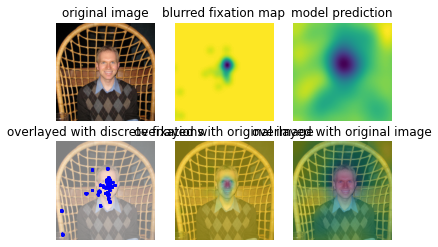

In [ ]:
# Third best
idx = best_idx[2]
with torch.no_grad():
  best_img = dataset_test[idx]['raw_image']
  best_fix = np.where(dataset_test[idx]['fixations_binary'])
  best_blurr = dataset_test[idx]['fixations_blurred']
  best_pred = model(torch.tensor(dataset_test[idx]['features'], dtype=torch.float).view(1, 512, 16, 16), centerbias).view(256,256)

plot(best_img, best_fix, best_blurr, best_pred)

**Display test images with lowest scores**

Here is an example for which the prediction is poor:

![alt text](https://i.imgur.com/g4rD2O1.png)

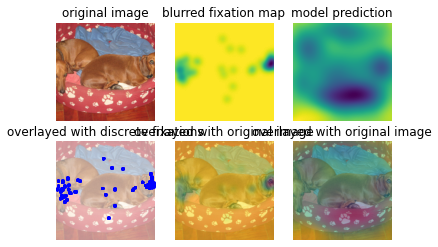

In [ ]:
# TODO
idx = worst_idx[0]
with torch.no_grad():
  best_img = dataset_test[idx]['raw_image']
  best_fix = np.where(dataset_test[idx]['fixations_binary'])
  best_blurr = dataset_test[idx]['fixations_blurred']
  best_pred = model(torch.tensor(dataset_test[idx]['features'], dtype=torch.float).view(1, 512, 16, 16), centerbias).view(256,256)

plot(best_img, best_fix, best_blurr, best_pred)

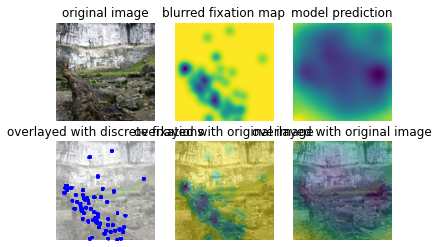

In [ ]:
# TODO
idx = worst_idx[1]
with torch.no_grad():
  best_img = dataset_test[idx]['raw_image']
  best_fix = np.where(dataset_test[idx]['fixations_binary'])
  best_blurr = dataset_test[idx]['fixations_blurred']
  best_pred = model(torch.tensor(dataset_test[idx]['features'], dtype=torch.float).view(1, 512, 16, 16), centerbias).view(256,256)

plot(best_img, best_fix, best_blurr, best_pred)

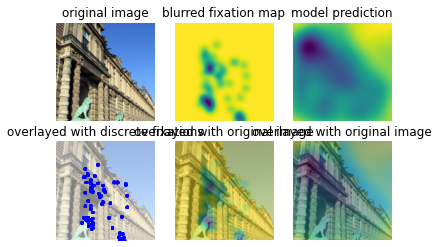

In [ ]:
# TODO
idx = worst_idx[2]
with torch.no_grad():
  best_img = dataset_test[idx]['raw_image']
  best_fix = np.where(dataset_test[idx]['fixations_binary'])
  best_blurr = dataset_test[idx]['fixations_blurred']
  best_pred = model(torch.tensor(dataset_test[idx]['features'], dtype=torch.float).view(1, 512, 16, 16), centerbias).view(256,256)

plot(best_img, best_fix, best_blurr, best_pred)